# NN cascade for STKA


# The code  (re-training and evaluation)

### Imports and axiliary functions and stuff

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [19]:
%load_ext sql
%matplotlib inline

In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/jupyter/instantclient_18_3:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64'
os.environ['PATH'] = '/jupyter/instantclient_18_3:/usr/local/mpi/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin'
os.environ['ORACLE_HOME']='/jupyter/instantclient_18_3'
os.environ['DYLD_LIBRARY_PATH']='/jupyter/instantclient_18_3'

In [2]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras

In [3]:
STA = 'STKA'

In [4]:
% sql select count(*) from ml_features where sta=STA

UsageError: Line magic function `%` not found.


In [51]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='accuracy')
    ax.plot(history['val_acc'], label='val_accuracy')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [6]:
#load data from oracle do pandas
#with open(os.path.join('/','jupyter','.dbpold.txt'), 'r') as f: password_old = f.read().strip()
import cx_Oracle
password_old = 'gagulek'
connection = cx_Oracle.connect('hofman[retraining]', password_old, 'dba1091.qandef')

In [5]:
#connection.close()

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [6]:
#select from database required numbers
#wrong_type = %sql select count(*) from ml_features where sta=STA and class_phase != class_iphase
#total_number = %sql select count(*) from ml_features where sta=STA and phase!='N' and source!='M'
#print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

In [7]:
from datetime import datetime as dt

In [8]:
dt.fromtimestamp(1483228800)

datetime.datetime(2017, 1, 1, 0, 0)

In [9]:
ts_2017 = dt(2017,1,1,0,0,0).timestamp()
ts_2018 = dt(2018,1,1,0,0,0).timestamp()
ts_2019 = dt(2019,1,1,0,0,0).timestamp()

### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2018

In [584]:
query = "select * from ml_features where sta='%s' and class_phase='regS' and time < %3.2f and retime<=10" % (STA, ts_2018)
df_S_all = pd.read_sql(query, con=connection)

In [585]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,37962741,STKA,1.187930e+09,Sn,regS,Sn,regS,0.0,M,0.500000,...,2.348496,2.155141,2.717578,0.3,0.273750,0.456043,0.193904,0.916166,0.912075,1.464293
1,37949162,STKA,1.188022e+09,P,T,Lg,regS,0.0,M,0.666667,...,3.393164,2.689957,2.689957,-0.4,-0.124333,0.301314,11.243244,1.373209,1.575558,1.774297
2,38128491,STKA,1.188513e+09,P,T,Lg,regS,0.0,M,0.333333,...,2.069752,0.665661,1.520149,0.0,-0.187690,0.237290,0.091610,0.627613,1.041864,0.416667
3,38338502,STKA,1.190183e+09,P,T,Lg,regS,0.0,M,0.444444,...,3.444478,1.273240,0.913128,-0.5,-0.156958,0.282948,0.944123,4.943968,0.462009,0.722558
4,38724474,STKA,1.191975e+09,Lg,regS,Lg,regS,0.0,M,0.588235,...,2.710894,3.529900,3.529900,0.1,-0.123604,0.409944,1.537586,4.411625,1.162837,0.728366


In [586]:
df_S_all.shape

(2331, 25)

In [587]:
query = "select * from ml_features where sta='%s' and class_phase='regP' and time < %3.2f and retime<=10" % (STA, ts_2018)
df_P_all = pd.read_sql(query, con=connection)

In [588]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,61575914,STKA,1.283408e+09,Pn,regP,Pg,regP,0.500,A,0.444444,...,1.870546,0.599377,0.719428,0.6,0.293375,0.340143,0.924220,2.618649,0.565146,0.509667
1,63459062,STKA,1.291030e+09,Pn,regP,Pn,regP,0.475,A,0.222222,...,3.221131,0.308925,0.308925,0.3,0.203417,6.795026,9.890656,1.378999,1.073409,0.251391
2,63468937,STKA,1.291061e+09,Pg,regP,Pg,regP,0.000,A,0.222222,...,3.681893,0.793199,0.459173,0.4,0.221312,0.892191,1.060609,0.992713,0.885562,0.684586
3,63523855,STKA,1.291267e+09,Pn,regP,Pn,regP,0.800,A,0.222222,...,2.727121,0.285870,0.344512,0.7,0.300357,0.634207,0.478616,0.808680,0.387517,0.419420
4,63523856,STKA,1.291267e+09,Px,regP,Pg,regP,0.250,A,0.444444,...,2.685962,0.417849,0.551800,0.6,0.255321,0.222681,0.304506,1.542246,0.447987,0.652520


In [589]:
df_P_all.shape

(1999, 25)

In [590]:
query = "select * from ml_features where sta='%s' and class_phase='T' and time < %3.2f and retime<=10" % (STA, ts_2018)
df_T_all = pd.read_sql(query, con=connection)

In [591]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,5525151,STKA,9.880337e+08,P,T,P,T,0.000000,A,0.333333,...,2.181812,0.190448,0.149119,0.2,0.102000,3.601241,0.658557,0.097867,0.234494,0.144150
1,5525288,STKA,9.880347e+08,P,T,P,T,0.000000,A,0.444444,...,5.972402,0.083586,0.101498,0.3,-0.274000,0.591032,0.120984,0.092644,0.082050,0.096420
2,5526727,STKA,9.880480e+08,P,T,P,T,0.000000,A,0.666667,...,5.440632,0.211600,0.211600,0.2,0.081000,0.150159,0.405730,0.272860,0.204547,0.292827
3,5527754,STKA,9.880606e+08,P,T,P,T,0.349999,A,0.666667,...,4.286809,0.122505,0.122505,0.3,0.172333,1.022422,0.554808,0.109871,0.117258,0.110303
4,8732522,STKA,1.017620e+09,P,T,P,T,3.200000,A,0.666667,...,2.099950,0.192245,0.192245,0.1,0.074500,1.557667,0.321546,1.168226,0.212608,0.796537


In [592]:
df_T_all.shape

(180083, 25)

In [593]:
query = "select * from ml_features where sta='%s' and class_phase='N' and time < %3.2f" % (STA, ts_2018)#  and retime=0"
df_N_all = pd.read_sql(query, con=connection)

In [594]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,102319,STKA,9.301086e+08,N,N,None,N,0.0,A,0.444444,...,1.676647,0.255580,0.255580,0.0,0.0000,0.231993,0.598643,0.471069,0.255277,0.328199
1,102345,STKA,9.301087e+08,N,N,None,N,0.0,A,0.444444,...,2.658390,3.516520,2.253499,0.0,0.0000,0.241002,0.986875,2.106621,0.591515,0.256666
2,102346,STKA,9.301089e+08,N,N,None,N,0.0,A,0.444444,...,1.195303,0.329460,0.973824,0.0,0.0000,0.885078,0.308068,1.727177,0.290626,0.300924
3,102347,STKA,9.301090e+08,N,N,None,N,0.0,A,0.444444,...,5.770905,1.613883,1.613883,0.0,0.0000,0.899696,0.631369,1.651362,0.556392,0.573599
4,102378,STKA,9.301098e+08,N,N,None,N,0.0,A,0.666667,...,2.935123,0.221281,0.221281,0.1,0.0945,0.304084,0.886704,0.397591,0.860885,0.837580


In [595]:
df_N_all.shape

(2636410, 25)

In [119]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [596]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (2331, 25)
regP (1999, 25)
tele (180083, 25)
noise (2636410, 25)


# Definition of input and output

In [597]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [598]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

nmult = 1
#sample TPS dataset, random_state is a seed
#excelusion of manual arrivals
#ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(nmult*nsa, random_state=11, replace=True)
#ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(nmult*npa, random_state=13, replace=True)
#ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(nmult*nta, random_state=17, replace=True)

#ssS = df_S_all.sample(nmult*ns, random_state=11)
#ssP = df_P_all.sample(nmult*np, random_state=13)
ssT = df_T_all.sample(nmult*nt, random_state=17)

ssS = df_S_all.sample(nmult*nt, random_state=11, replace=True)
ssP = df_P_all.sample(nmult*nt, random_state=13, replace=True)
#ssT = df_T_all.sample(nmult*nt, random_state=17, replace=True)


TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
#N_data = df_N_all.sample(4*nmult*(nsa+npa+nta), random_state=23)
N_data = df_N_all.sample(frac=1, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(180083, 25) (180083, 25) (180083, 25)
(540249, 25)
(2636410, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [599]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [600]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [601]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9866848740648668772
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2784140169012331418
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12064742225572144821
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 771817472
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 2795664842954033246
physical_device_desc: "device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
mem

In [602]:
from tensorflow.keras import backend as K
#K._get_available_gpus()
print(dir(K))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abs', 'all', 'any', 'arange', 'argmax', 'argmin', 'backend', 'batch_dot', 'batch_flatten', 'batch_get_value', 'batch_normalization', 'batch_set_value', 'bias_add', 'binary_crossentropy', 'cast', 'cast_to_floatx', 'categorical_crossentropy', 'clear_session', 'clip', 'concatenate', 'constant', 'conv1d', 'conv2d', 'conv2d_transpose', 'conv3d', 'cos', 'count_params', 'ctc_batch_cost', 'ctc_decode', 'ctc_label_dense_to_sparse', 'dot', 'dropout', 'dtype', 'elu', 'epsilon', 'equal', 'eval', 'exp', 'expand_dims', 'eye', 'flatten', 'floatx', 'foldl', 'foldr', 'function', 'gather', 'get_session', 'get_uid', 'get_value', 'gradients', 'greater', 'greater_equal', 'hard_sigmoid', 'image_data_format', 'in_test_phase', 'in_top_k', 'in_train_phase', 'int_shape', 'is_sparse', 'l2_normalize', 'learning_phase', 'less', 'less_equal', 'log', 'manual_variable_initialization', 'map_fn', 'max

In [603]:
import tensorflow.keras.utils
from tensorflow.keras.utils import multi_gpu_model

### Define train/validation ratio

In [604]:
train_validation_split_ratio = 0.99
samp_count_train = int(TPS_data_norm.shape[0] * train_validation_split_ratio)
samp_count_valid = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_valid)

train count= 534846 test count= 5403


In [605]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_valid = TPS_data_norm[samp_count_train:]

samp_count_train_N = int(N_data_norm.shape[0] * train_validation_split_ratio)

N_train = N_data_norm[:samp_count_train_N]
N_valid = N_data_norm[samp_count_train_N:]

print('TPS train:',TPS_train.shape,'TPS valid:',TPS_valid.shape)
print('N train:  ',N_train.shape,  'N valid:  ',N_valid.shape)

TPS train: (534846, 25) TPS valid: (5403, 25)
N train:   (2610045, 25) N valid:   (26365, 25)


In [503]:
120000./(2500000+120000)

0.04580152671755725

### Check interclass balance of TPS

In [606]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='T'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_valid[TPS_valid['CLASS_PHASE']=='T'].shape)
print('regP in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (178266, 25)
regP in TPS train: (178332, 25)
regS in TPS train: (178248, 25)
T in TPS test:     (1817, 25)
regP in TPS test:  (1751, 25)
regS in TPS test:  (1835, 25)


### Form train and test sets and shuffle

In [607]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
valid =  pd.concat([TPS_valid, N_valid]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

In [506]:
#numpy.savez(f'train_{STA}', train)
#numpy.savez(f'valid_{STA}', valid)

#train = numpy.load('train_STKA.npz')['arr_0']
#valid = numpy.load('valid_STKA.npz')['arr_0']

In [507]:
#d = numpy.load('STKA.npz') 
#train_X=d['train_X'] #, 
#train_Y=d['train_Y']
#valid_X=d['valid_X']
#valid_Y=d['valid_Y']
#train_Y_GT=d['train_Y_GT']
#valid_Y_GT=d['valid_Y_GT']

### Extract features and class labels

In [508]:
metadata

['ARID',
 'STA',
 'TIME',
 'IPHASE',
 'CLASS_IPHASE',
 'PHASE',
 'CLASS_PHASE',
 'RETIME',
 'SOURCE']

In [608]:

train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

valid_X = valid[x_indices].values.astype(float)
valid_Y = valid[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
valid_Y_ = numpy.array(numpy.where(valid_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = tensorflow.keras.utils.to_categorical(train_Y_)
valid_Y = tensorflow.keras.utils.to_categorical(valid_Y_)

valid_metadata = valid[metadata]

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)
print(valid_metadata.shape)
print('N phases:', train_Y_.sum())

(3144891, 15) (3144891, 2) (31768, 15) (31768, 2)
(31768, 9)
N phases: 2610045.0


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [609]:
train[y_indices+x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,0.333333,0.799879,0.849027,0.536454,0.990279,0.489868,-0.065429,-0.185762,0.2,0.421875,-0.406010,0.197839,0.225539,0.043919,-0.287843
1,N,0.666667,0.883050,0.803814,0.582641,0.950423,0.488812,-0.100421,-0.432582,0.0,0.000000,-0.043064,-0.387065,0.131574,-0.329634,-0.351259
2,N,0.333333,0.750510,0.765218,0.949594,0.839120,0.060089,0.477712,0.140585,0.0,0.000000,-0.500024,0.099820,-0.020446,-0.134478,-0.109512
3,N,0.222222,0.772479,0.733530,0.244055,0.642390,0.216552,-0.498270,-0.131392,0.6,0.269107,-0.861356,-0.400176,-0.377830,-0.735615,-0.158630
4,N,0.303030,0.702526,0.975605,0.437948,0.622785,0.557322,-0.219263,-0.071926,0.2,0.069167,0.028404,-0.413333,-0.417302,-0.470490,-0.283974


In [610]:
train_Y[:5]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

#### Ground truth for all 4 classes

In [611]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'T'])
valid_Y_GT = le.transform(valid[y_indices])
train_Y_GT = le.transform(train[y_indices])
print(le.transform(['N', 'regP', 'regS', 'T']))
train_Y_GT[:200]

[0 2 3 1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 3, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [612]:
X_nans = numpy.isnan(train_X)
X_nans.shape, train_X.shape
train_X
X_nans

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

# Neural network N vs TPS

#### This section is based on retime=0 data with 4 times more noise than associated phases

In [613]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [614]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

#model_gpu = multi_gpu_model(model, gpus=1)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

In [615]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [616]:
#hist_keys = ('accuracy', 'val_accuracy', 'loss', 'val_loss')
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [522]:
470000./3079000

0.15264696329977265

In [617]:
history = {k : [] for k in hist_keys}

In [685]:
class_weight = {0 : 1.,  # PST 1 to loss
                1: 0.053}  # noise = 0.1 weights to loss

h = model.fit(train_X[:], train_Y[:], 
          epochs=2, 
          batch_size=512, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(valid_X, valid_Y),
          class_weight=class_weight)

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 3144891 samples, validate on 31768 samples
Epoch 1/2
3144891/3144891 [==============================] - 36s 12us/step - loss: 0.0695 - acc: 0.5922 - val_loss: 0.7979 - val_acc: 0.5885
Epoch 2/2
3144891/3144891 [==============================] - 36s 11us/step - loss: 0.0694 - acc: 0.5927 - val_loss: 0.7912 - val_acc: 0.5935


In [79]:
print(train_Y[train_Y[:,0]==1].shape, train_Y[train_Y[:,1]==1].shape)
print(valid_Y[valid_Y[:,0]==1].shape, valid_Y[valid_Y[:,1]==1].shape)

(14467, 2) (374383, 2)
(762, 2) (19705, 2)


In [80]:
valid_Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

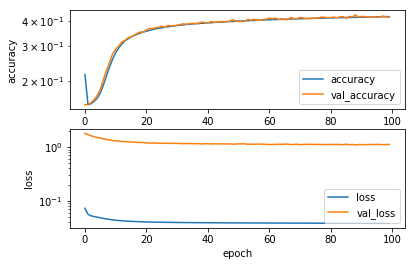

In [528]:
plot(history, semilog=True)

In [82]:
#model = load_model(f'h5/{STA}_NTPS4.h5')

In [686]:
# calculate predicted values
Y_pred_ = model.predict(valid_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])
print(Y_pred_.shape)
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred, valid_Y_)
print(conf_mat)

#[[ 4650 18014]
# [   92  8351]]

[[ 0.38028252  0.61822259]
 [ 0.3832821   0.6028977 ]
 [ 0.81461114  0.18875194]
 [ 0.84839076  0.14768074]
 [ 0.57343161  0.42940742]
 [ 0.98883665  0.01163059]
 [ 0.64957052  0.35808641]
 [ 0.30635729  0.69311857]
 [ 0.36478129  0.63027972]
 [ 0.17337683  0.82535088]]
(31768, 2)
[[ 5083 12608]
 [  320 13757]]


In [533]:
150000./(2650000)

636/(4750.)

0.13389473684210526

In [263]:
#pred_r = numpy.argmax(model.predict(train_X[:]), axis=1)
#train_Y_r = numpy.argmax(train_Y[:], axis=1)
#delta = numpy.abs(pred_r - train_Y_r)
#print(sum(delta))
#d = {1: False, 0: True}

#delta = [d[x] for x in delta]

In [282]:
train_X[:], train_Y[:]
train_X_new = train_X[delta]
train_Y_new = train_Y[delta]
print(train_X_new.shape, train_Y_new.shape, train_X.shape, len(delta))


(625225, 15) (625225, 2) (1088546, 15) 1088546


In [258]:
## confusion matrix on Train?
pred = model.predict(train_X)
#Y_pred = numpy.argmax(, axis=1)
Y_pred = numpy.zeros((pred.shape[0], 1))

#example of threshold other that 0.5:
Y_pred[pred[:,1]>=0.55] = 1

conf_mat = confusion_matrix(Y_pred, train_Y_)
print(conf_mat)

[[ 72739 512402]
 [  3224 500181]]


In [ ]:
[[ 35783  94130]
 [  2027 200218]]

In [55]:
#eval on test data
model.evaluate(valid_X, valid_Y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.5864308867146444, 0.7418062]

In [79]:
model.evaluate(train_X, train_Y)

2624083/2624083 [==============================] - 100s 38us/step


[0.79746747130944717, 0.62734048427581768]

In [687]:
#save model and weights, NTC = contextual features correct, Rt => retime <= t seconds
filename = 'h5/%s_NTPS22.h5' % STA
model.save(filename)
print('saved as filename %s' % filename)

saved as filename h5/STKA_NTPS22.h5


# Neural network TP vs S 

#### This section is based on retime=2 data

* we need a new dataset for this

## Dataset for TP vs S

In [692]:
print(TPS_train.shape, TPS_valid.shape)

(534846, 25) (5403, 25)


In [694]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

valid_X_TPS = TPS_valid[x_indices].values.astype(float)
valid_Y_TPS = TPS_valid[y_indices]

#regS = 1, T/regP = 0
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
valid_Y_TPS_ = numpy.array(numpy.where(valid_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = tensorflow.keras.utils.to_categorical(train_Y_TPS_)
valid_Y_TPS = tensorflow.keras.utils.to_categorical(valid_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, valid_X_TPS.shape, valid_Y_TPS.shape)
print('regS:', train_Y_TPS_.sum())
print('regS:', valid_Y_TPS_.sum())

(534846, 15) (534846, 2) (5403, 15) (5403, 2)
regS: 178248.0
regS: 1835.0


### test if node3 < 0.5 => S

In [565]:
TPS_train[y_indices+x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,regP,0.333333,0.924218,0.797151,0.219405,0.663783,0.307095,-0.846689,0.168198,0.1,0.088000,-0.406204,-0.360450,-0.214286,-0.400728,-0.256252
1,regP,0.333333,0.976131,0.962204,0.488376,0.889358,0.626314,-0.313891,-0.313891,0.6,0.333333,-1.036888,-0.050725,0.083707,-0.328587,-0.436101
2,regP,0.222222,0.737364,0.540498,0.753252,0.943476,0.283936,-0.004276,-0.443488,0.8,0.316063,-0.616318,-0.250030,-0.557032,0.005718,-0.061732
3,regS,0.444444,0.950208,0.929144,0.453952,0.674149,0.692590,-0.396520,-0.605777,0.1,-0.005013,-0.433793,-0.228665,0.050126,-0.330187,-0.323473
4,regP,0.444444,0.709040,0.726401,0.947489,0.602207,0.273199,0.119047,0.036781,0.7,0.294786,-0.419774,-0.191082,0.443259,-0.150232,-0.078510


In [566]:
train_Y_TPS[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32)

### Neural network

In [567]:
history_TPS = {k : [] for k in hist_keys}

n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # 'adam', 'sgd'
    metrics = ['accuracy'])

In [568]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [569]:
class_weight = {0 : 0.66,  # PT is five times more abundant
                1: 1.}  # S = 1 weights to loss
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=20, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TPS, valid_Y_TPS]),
          class_weight=class_weight)

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 469396 samples, validate on 4742 samples
Epoch 1/20
469396/469396 [==============================] - 26s 55us/step - loss: 0.4631 - acc: 0.7510 - val_loss: 0.4906 - val_acc: 0.8388
Epoch 2/20
469396/469396 [==============================] - 19s 40us/step - loss: 0.3464 - acc: 0.8524 - val_loss: 0.3816 - val_acc: 0.8593
Epoch 3/20
469396/469396 [==============================] - 19s 40us/step - loss: 0.2844 - acc: 0.8658 - val_loss: 0.3322 - val_acc: 0.8664
Epoch 4/20
469396/469396 [==============================] - 19s 40us/step - loss: 0.2554 - acc: 0.8753 - val_loss: 0.3057 - val_acc: 0.8760
Epoch 5/20
469396/469396 [==============================] - 19s 41us/step - loss: 0.2413 - acc: 0.8787 - val_loss: 0.2940 - val_acc: 0.8759
Epoch 6/20
469396/469396 [==============================] - 19s 41us/step - loss: 0.2350 - acc: 0.8786 - val_loss: 0.2870 - val_acc: 0.8757
Epoch 7/20
469396/469396 [==============================] - 19s 40us/step - loss: 0.2318 - acc: 0.8785 - val_l

KeyboardInterrupt: 

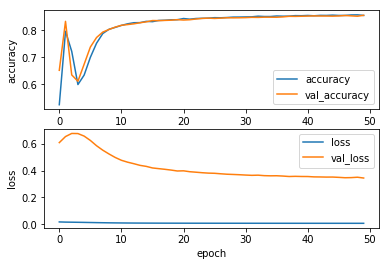

In [298]:
plot(history_TPS)

In [67]:
model_TPS.evaluate(valid_X_TPS, valid_Y_TPS)

8073/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4450667797300905, 0.8182212]

In [118]:
min(valid_Y_TPS_), max(valid_Y_TPS_)
valid_Y_TPS_.shape
sum(valid_Y_TPS_)

6.0

#### Test data confusion matrix

In [570]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(valid_X_TPS), axis=1), (valid_X_TPS.shape[0],1))
print(Y_pred.shape)
# calculate confusion matrix
C = confusion_matrix(Y_pred, valid_Y_TPS_)
print(C)

(4742, 1)
[[2912  271]
 [ 302 1257]]


In [70]:
print(valid_X_TPS.shape)
print(valid_Y_TPS.shape)
print(valid_Y_TPS_.shape)
print(min(Y_pred), max(Y_pred))
print(min(valid_Y_TPS_), max(valid_Y_TPS_))
print(sum(valid_Y_TPS_), sum(Y_pred))

(8073, 15)
(8073, 2)
(8073,)
[0] [1]
0.0 1.0
93.0 [1552]


In [71]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 81.78%


In [571]:
#NC = nodes correct
filename = 'h5/%s_TPS4.h5' % STA
model_TPS.save(filename)
print('saved as %s' % filename)

saved as h5/STKA_TPS4.h5


# Neural network T vs regP 

#### This section is based on retime=2 data

* we need a new dataset for this

### Dataset for T vs regP

In [695]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_valid  = TPS_valid [TPS_valid ['CLASS_PHASE'] != 'regS']

train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

valid_X_TP = TP_valid[x_indices].values.astype(float)
valid_Y_TP = TP_valid[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
valid_Y_TP_ = numpy.array(numpy.where(valid_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = tensorflow.keras.utils.to_categorical(train_Y_TP_)
valid_Y_TP = tensorflow.keras.utils.to_categorical(valid_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, valid_X_TP.shape, valid_Y_TP.shape)
print(sum(train_Y_TP_))

(356598, 15) (356598, 2) (3568, 15) (3568, 2)
178332.0


### test if node5 < 0.5 => P

In [77]:
TP_train[y_indices + x_indices].head()

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,T,0.666667,0.988561,0.987166,0.234733,0.767846,0.424546,-1.059461,-1.059461,0.2,-0.264062,0.289226,0.012598,-0.981639,-0.491583,-0.475251
1,T,0.333333,0.858103,0.901601,0.503366,0.579853,0.177798,-0.245295,0.176910,0.0,0.000000,0.157944,-0.148963,0.260148,-0.627494,-0.097257
2,T,0.666667,0.988846,0.981172,0.308953,0.954561,0.690060,-0.820978,-0.820978,0.3,0.317500,-0.566609,-0.061852,-0.873210,-0.836253,-0.611204
3,T,0.444444,0.908131,0.935541,0.346245,0.672497,0.193298,-0.539004,-0.544134,0.2,0.228500,0.277246,0.176383,-0.638328,-0.680244,-0.448655
4,T,0.444444,0.993808,0.992420,0.154318,0.897932,0.256252,-1.431285,-1.528403,0.0,0.000000,-0.510094,-0.038054,-1.276764,-1.712880,-1.020843


In [78]:
train_Y_TP[:5]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

### Neural network

In [696]:
history_TP = {k : [] for k in hist_keys}
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

adam = Adam(lr=0.0001)

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # 'adam', sgd
    metrics = ['accuracy'])

In [703]:
class_weight = {0 : 1, #0.01,  # T is several times more abundant
                1: 1.1}  # P
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=10, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TP, valid_Y_TP]),
          class_weight=class_weight)

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 356598 samples, validate on 3568 samples
Epoch 1/10
356598/356598 [==============================] - 15s 43us/step - loss: 0.2986 - acc: 0.8836 - val_loss: 0.2811 - val_acc: 0.8873
Epoch 2/10
356598/356598 [==============================] - 15s 43us/step - loss: 0.2949 - acc: 0.8846 - val_loss: 0.2778 - val_acc: 0.8873
Epoch 3/10
356598/356598 [==============================] - 15s 43us/step - loss: 0.2922 - acc: 0.8859 - val_loss: 0.2753 - val_acc: 0.8883
Epoch 4/10
356598/356598 [==============================] - 15s 42us/step - loss: 0.2900 - acc: 0.8873 - val_loss: 0.2731 - val_acc: 0.8901
Epoch 5/10
356598/356598 [==============================] - 15s 43us/step - loss: 0.2883 - acc: 0.8880 - val_loss: 0.2714 - val_acc: 0.8910
Epoch 6/10
356598/356598 [==============================] - 15s 43us/step - loss: 0.2868 - acc: 0.8888 - val_loss: 0.2700 - val_acc: 0.8929
Epoch 7/10
356598/356598 [==============================] - 15s 41us/step - loss: 0.2857 - acc: 0.8893 - val_l

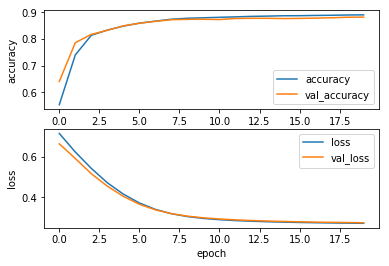

In [373]:
plot(history_TP)

In [372]:
#model_TP.evaluate(valid_X_TP, valid_Y_TP)

#### Test data confusion matrix

In [370]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(valid_X_TP), axis=1), (valid_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred, valid_Y_TP_)
print(conf_mat)

[[1623  226]
 [ 194 1525]]


In [704]:
filename = 'h5/%s_TP5.h5' % STA
model_TP.save(filename)
print('saved as %s' % filename)

saved as h5/STKA_TP5.h5


In [ ]:
[[624 102]
 [ 87 251]]

In [498]:
pred_r = numpy.argmax(model.predict(train_X_TP[:]), axis=1)
train_Y_TP_r = numpy.argmax(train_Y_TP[:], axis=1)
delta_TP = numpy.abs(pred_r - train_Y_TP_r)
print(sum(delta_TP))
d = {1: False, 0: True}

delta_TP = [d[x] for x in delta_TP]
print(len(delta_TP), train_X_TP.shape)

9069
75009 (75009, 15)


# Cascade of all three models

In [108]:
%ls -l h5/

total 140
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:39 STKA_NTPS1.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 14:28 STKA_NTPS.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:55 STKA_TP1.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:53 STKA_TP.h5
-rw-rw-r-- 1 hofman hofman 25512 Nov 18 15:47 STKA_TPS.h5


In [88]:
from tensorflow.keras.models import load_model

In [549]:
model_NTPS = load_model('h5/%s_NTPS14.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)

In [550]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # 0 # N
    Y[S_indices] = 3 # 2 # regS
    Y[P_indices] = 2 # 1 # regP 
    Y[T_indices] = 1 # 3 # tele
    
    return Y
    

In [551]:
Y = predict_iwt(valid_X)

### Overall confusion matrix for test data

In [205]:
valid_X.shape, Y.shape, valid_Y_GT.shape

((141042, 15), (141042,), (141042,))

In [552]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(Y, valid_Y_GT)
print(C)

[[15049   149    27   133]
 [ 4622  1246   140   122]
 [  959   119  1352   140]
 [ 5735   103    78  1133]]


In [553]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Assoc accuracy: %3.2f%%' % ((numpy.diag(C)[1:].sum())/(C[:,1:].sum())*100))
print('Overal accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

Assoc accuracy: 78.68%
Overal accuracy: 60.37%
N phase rate: 6.52%


In [554]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Assoc accuracy: %3.2f%%' % ((numpy.diag(C)[1:].sum())/(C[:,1:].sum())*100))
print('Overal accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

Assoc accuracy: 78.68%
Overal accuracy: 60.37%
N phase rate: 6.52%


Assoc accuracy: 74.30%
Overal accuracy: 75.83%
N phase rate: 10.73%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [249]:
print(sum(valid_TPS['CLASS_IPHASE'][valid_TPS['CLASS_IPHASE'] == None]))
#valid_TPS_iphase_Y = le.transform(valid_TPS['CLASS_IPHASE'])
set(valid_TPS['CLASS_IPHASE'])

0


{'N', 'T', 'regP', 'regS'}

In [555]:
valid_TPS = valid[valid['CLASS_PHASE'] != 'N']
valid_TPS_X = valid_TPS[x_indices]
valid_TPS_pred_Y = predict_iwt(valid_TPS_X)
valid_TPS_truth_Y = le.transform(valid_TPS['CLASS_PHASE'])
valid_TPS_iphase_Y = le.transform(valid_TPS['CLASS_IPHASE'])

In [251]:
valid_TPS_iphase_Y.min(), valid_TPS_iphase_Y.max()

(0, 3)

In [252]:
print('IPHASE:')
C = confusion_matrix(valid_TPS_iphase_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

IPHASE:
[[   0  162    3    4]
 [   0 1370    3    3]
 [   0  256   16    6]
 [   0   14    0    8]]
Accuracy: 75.56%
N phase rate: 9.16%


In [253]:
print('NEW PREDICTION')
C = confusion_matrix(valid_TPS_pred_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (C[0,1:].sum()/C[:,1:].sum()*100))

NEW PREDICTION
[[   0   83    2   11]
 [   0 1421    1    4]
 [   0  108   12    1]
 [   0  190    7    5]]
Accuracy: 77.94%
N phase rate: 5.20%


* in the test data, the current iwt characterized 166 as NOISE (first row of confusion matrix)
* our new iwt would characterize 49 as NOISE
* after re-training, accuracy on the test set rose from 59.14% to 71.53% for regS, regP and T phases

# Prediction on 2018 - today

### Load data

In [556]:
query = "select * from ml_features where sta='%s' and class_phase='regS' and time > %3.2f" % (STA, ts_2018) #" and time < {ts_2019}"
df_S_2017 = pd.read_sql(query, con=connection)
query = "select * from ml_features where sta='%s' and class_phase='regP' and time > %3.2f" % (STA, ts_2018) #" and time < {ts_2019}"
df_P_2017 = pd.read_sql(query, con=connection)
query = "select * from ml_features where sta='%s' and class_phase='T' and time > %3.2f" % (STA, ts_2018) #" and time < {ts_2019}"
df_T_2017 = pd.read_sql(query, con=connection)
query = "select * from ml_features where sta='%s' and class_phase='N' and time >  %3.2f" % (STA, ts_2018) #" and time < {ts_2019}"
df_N_2017 = pd.read_sql(query, con=connection)
print(df_S_2017.shape, df_P_2017.shape, df_T_2017.shape, df_N_2017.shape)

(126, 25) (96, 25) (15229, 25) (253549, 25)


In [557]:
data_2017 = pd.concat([df_P_2017, df_S_2017, df_T_2017])
data_2017_wN = pd.concat([df_P_2017, df_S_2017, df_T_2017, df_N_2017])

In [558]:
test_TPS_iphase_Y_2017 = le.transform(data_2017['CLASS_IPHASE'])
test_NTPS_iphase_Y_2017 = le.transform(data_2017_wN['CLASS_IPHASE'])

In [211]:
data_2017_X = data_2017[x_indices]

data_2017_norm = data_2017[x_indices].copy(deep=True)
data_2017_norm['INANG1'] /= 90.
data_2017_norm['INANG3'] /= 90.
data_2017_norm['HMXMN'] = numpy.log10(data_2017_X['HMXMN'])
data_2017_norm['HVRATP'] = numpy.log10(data_2017_X['HVRATP'])
data_2017_norm['HVRAT'] = numpy.log10(data_2017_X['HVRAT'])
data_2017_norm['HTOV1'] = numpy.log10(data_2017_X['HTOV1'])
data_2017_norm['HTOV2'] = numpy.log10(data_2017_X['HTOV2'])
data_2017_norm['HTOV3'] = numpy.log10(data_2017_X['HTOV3'])
data_2017_norm['HTOV4'] = numpy.log10(data_2017_X['HTOV4'])
data_2017_norm['HTOV5'] = numpy.log10(data_2017_X['HTOV5'])

data_2017_X_wN = data_2017_wN[x_indices]

data_2017_norm_wN = data_2017_wN[x_indices].copy(deep=True)
data_2017_norm_wN['INANG1'] /= 90.
data_2017_norm_wN['INANG3'] /= 90.
data_2017_norm_wN['HMXMN'] = numpy.log10(data_2017_X_wN['HMXMN'])
data_2017_norm_wN['HVRATP'] = numpy.log10(data_2017_X_wN['HVRATP'])
data_2017_norm_wN['HVRAT'] = numpy.log10(data_2017_X_wN['HVRAT'])
data_2017_norm_wN['HTOV1'] = numpy.log10(data_2017_X_wN['HTOV1'])
data_2017_norm_wN['HTOV2'] = numpy.log10(data_2017_X_wN['HTOV2'])
data_2017_norm_wN['HTOV3'] = numpy.log10(data_2017_X_wN['HTOV3'])
data_2017_norm_wN['HTOV4'] = numpy.log10(data_2017_X_wN['HTOV4'])
data_2017_norm_wN['HTOV5'] = numpy.log10(data_2017_X_wN['HTOV5'])

In [212]:
data_2017_Y = numpy.zeros(data_2017.shape[0])
data_2017_Y[:df_P_2017.shape[0]] = 2
data_2017_Y[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y[df_P_2017.shape[0]+df_S_2017.shape[0]:] = 1

data_2017_Y_wN = numpy.zeros(data_2017_wN.shape[0])
data_2017_Y_wN[:df_P_2017.shape[0]] = 2
data_2017_Y_wN[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y_wN[df_P_2017.shape[0]+df_S_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]+df_T_2017.shape[0]] = 1

### Predict and evaluate

In [716]:
model_NTPS = load_model('h5/%s_NTPS20.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)

In [717]:
data_2017_pred = predict_iwt(data_2017_norm)
data_2017_pred_wN = predict_iwt(data_2017_norm_wN)
print(data_2017_norm.shape[0], data_2017_norm_wN.shape[0])

15451 269000


In [718]:
C = confusion_matrix(data_2017_pred, data_2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,:].sum()/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

[[    0  1197     2    15]
 [    0 12215    14    11]
 [    0  1110    72    12]
 [    0   707     8    88]]
Accuracy: 80.09%
N phase rate: 7.86%


In [562]:
print('old:')
C = confusion_matrix(test_NTPS_iphase_Y_2017, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,1:].sum()/C[:,1:].sum()
ass_accuracy = numpy.diag(C)[1:].sum()/C[:,1:].sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('Assoc accuracy: %3.2f%%' % (ass_accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

old:
[[150929   1287      7     35]
 [ 69094  11442     11      5]
 [ 20904   2447     78     34]
 [ 12622     53      0     52]]
Accuracy: 60.41%
Assoc accuracy: 74.89%
N phase rate: 8.60%


In [719]:
print('new:')
C = confusion_matrix(data_2017_pred_wN, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,1:].sum()/C[:,1:].sum()
ass_accuracy = numpy.diag(C)[1:].sum()/C[:,1:].sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('Assoc accuracy: %3.2f%%' % (ass_accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

new:
[[154555   1197      2     15]
 [ 29209  12215     14     11]
 [ 10840   1110     72     12]
 [ 58945    707      8     88]]
Accuracy: 62.06%
Assoc accuracy: 80.09%
N phase rate: 7.86%


model_NTPS = load_model('h5/%s_NTPS20.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)
new:
[[154555   1197      2     15]
 [ 29209  12215     14     11]
 [ 10840   1110     72     12]
 [ 58945    707      8     88]]
Accuracy: 62.06%
Assoc accuracy: 80.09%
N phase rate: 7.86%

model_NTPS = load_model('h5/%s_NTPS19.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)
new:
[[152281   1195      2     15]
 [ 29446  12216     14     11]
 [ 11053   1110     72     12]
 [ 60769    708      8     88]]
Accuracy: 61.21%
Assoc accuracy: 80.10%
N phase rate: 7.84%

model_NTPS = load_model('h5/%s_NTPS18.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)
new:
[[151059   1219      2     15]
 [ 29425  12201     14     12]
 [ 11237   1110     72     12]
 [ 61828    699      8     87]]
Accuracy: 60.75%
Assoc accuracy: 79.99%
N phase rate: 8.00%

model_NTPS = load_model('h5/%s_NTPS13.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)
new:
[[159461   1265      2     11]
 [ 28770  12149     15     13]
 [  9834   1103     72     12]
 [ 55484    712      7     90]]
Accuracy: 63.86%
Assoc accuracy: 79.68%
N phase rate: 8.27%

model_NTPS = load_model('h5/%s_NTPS12.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)
new:
[[ 93261    511      0      3]
 [ 45281  12640     16     13]
 [ 13288   1117     72     12]
 [101719    961      8     98]]
Accuracy: 39.43%
Assoc accuracy: 82.91%
N phase rate: 3.33%

model_NTPS = load_model('h5/%s_NTPS11.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)

new:
[[155058   1291      2     12]
 [ 26924  12125     14     12]
 [  9656   1106     72     12]
 [ 61911    707      8     90]]
Accuracy: 62.21%
Assoc accuracy: 79.52%
N phase rate: 8.45%


model_NTPS = load_model('h5/%s_NTPS7.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)

new:
[[150744   1153      2     16]
 [ 29321  12256     14     11]
 [ 10417   1111     72     12]
 [ 63067    709      8     87]]
Accuracy: 60.65%
Assoc accuracy: 80.35%
N phase rate: 7.58%


In [722]:
summary = "Training Summary: Accuracy: %3.2f%%, assoc accuracy: %3.2f%%, Nphaserate: %3.2f%%, assoc. ph: %d, noise ph: %d" % (accuracy*100, ass_accuracy*100, nphaserate*100, data_2017_norm.shape[0], data_2017_norm_wN.shape[0])
print(summary)

Training Summary: Accuracy: 62.06%, assoc accuracy: 80.09%, Nphaserate: 7.86%, assoc. ph: 15451, noise ph: 269000


In [262]:
 data_2017_Y_wN.shape

(269000,)

In [289]:
print('N', data_2017_Y_wN[data_2017_Y_wN==0].shape)
print('P', data_2017_Y_wN[data_2017_Y_wN==1].shape)
print('S', data_2017_Y_wN[data_2017_Y_wN==2].shape)
print('T', data_2017_Y_wN[data_2017_Y_wN==3].shape)

N (84689,)
P (4520,)
S (31,)
T (13,)


## Overall results on train data just to see if it works...

In [290]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[279677    678      1      9]
 [ 76021  12662     16     14]
 [  9220    535     46     10]
 [  9465    460      2     34]]
Accuracy: 75.20%


# Let's analyze weights and generate a new NN weight file!

In [720]:
model_NTPS = load_model('h5/%s_NTPS20.h5' % STA)
model_STP = load_model('h5/%s_TPS3.h5' % STA)
model_PT = load_model('h5/%s_TP3.h5' % STA)

In [721]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [723]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'batch_input_shape': (None, 15),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'dtype': 'float32',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_24',
   'trainable': True,
   'units': 6,
   'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution'

In [724]:
for w in weights_NTPS:
    print(w.shape)
    print(w)

(15, 6)
[[  7.56917775e-01  -2.35255504e+00   7.65541196e-01   4.53144684e-03
    7.58330524e-01   1.34421349e+00]
 [ -2.33661580e+00   1.63493907e+00  -2.14853954e+00   6.97410226e-01
    2.72922921e+00  -2.07946348e+00]
 [  4.49789584e-01   3.48951459e-01   4.65241790e-01  -1.05629885e+00
   -2.83221751e-01   6.37855709e-01]
 [ -1.98641217e+00  -3.40043455e-01   3.70239429e-02  -2.45733157e-01
    6.49375692e-02   7.73924589e-01]
 [  9.71065938e-01  -1.18397152e+00   1.49980187e-01   6.45707369e-01
   -1.07245660e+00   5.20695508e-01]
 [  3.79576653e-01  -3.54558527e-02  -3.51583987e-01  -1.76390696e+00
   -2.46315956e-01   1.32756934e-01]
 [ -3.20391834e-01  -7.98643157e-02  -1.51530832e-01   1.35278240e-01
   -2.21837783e+00   5.04256964e-01]
 [ -2.12494135e+00  -1.21231794e+00  -6.66713655e-01   1.96726590e-01
    1.56303155e+00   1.22136724e+00]
 [ -3.18760902e-01   1.03529663e+01   1.27944171e+00  -7.41865826e+00
   -1.43001509e+00  -2.17476940e+00]
 [  8.28604996e-02  -2.622252

In [725]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[ 1.86615348  1.38935828 -1.26471663 -1.8731612   0.97519392 -0.96397102]
 [-0.22599943 -0.67672002  0.62429768  0.81854588 -0.73694259  0.70788032]
 [-1.10957158 -0.65853453  0.662422    0.8324821  -1.25061166  0.8133074 ]
 [ 0.73702765  0.41055235  0.01186336 -0.05330023  0.36923355 -0.46392694]
 [ 0.18499261  0.09972745 -0.50222194 -0.24632673  0.55715203 -0.31066394]
 [-0.80999601 -0.97041661  0.45459178  0.30119503 -0.17247166  0.55994886]
 [ 0.38786018  0.27388772 -0.48935172  0.03272159 -0.22977954  0.09053037]
 [ 0.13397112  0.6748845  -0.2820529  -0.85922396  0.21468133 -0.07234704]
 [-1.8351686  -1.46810687  1.67872691  1.49318194 -2.02687502  2.17417455]
 [-0.06572793 -0.38127238  0.48837963  0.25049791 -0.40914947  0.25199187]
 [ 0.09887197 -0.46459013  0.14620087  0.31910518 -0.13330261 -0.23712595]
 [ 0.21431506  0.25989369 -0.04458402 -0.28018397  0.09555108  0.24558881]
 [ 0.76202959  0.93407589 -0.48677602 -0.78603274  0.414258   -0.40116146]
 [ 1.01826096  1.

In [726]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[  2.59365892e+00  -2.51419640e+00  -1.84833443e+00  -2.58500648e+00
   -1.96929395e+00  -2.63639927e+00]
 [  1.77771628e-01   6.07430100e-01   6.82847381e-01   4.29132789e-01
    4.03228492e-01   1.02152728e-01]
 [  4.06784385e-01   7.52683654e-02   2.43937209e-01   2.65060335e-01
    1.07714660e-01   4.28864449e-01]
 [  2.88460702e-01  -9.03543681e-02   7.75216162e-01  -1.84927121e-01
   -7.82901168e-01   2.13947203e-02]
 [ -7.49441922e-01   4.61290747e-01   5.85251689e-01   7.87074685e-01
    6.71486497e-01   4.20670450e-01]
 [ -2.22242519e-01  -1.11011758e-01   4.86831397e-01   1.65077969e-01
   -2.51386523e-01   2.46737763e-01]
 [  6.37313277e-02   9.07569379e-02   5.46461403e-01   1.61065072e-01
    2.59634554e-01   1.69286653e-01]
 [  4.42131832e-02   3.51430744e-01   1.03759217e+00   3.92616361e-01
   -9.24136266e-02   5.86864315e-02]
 [ -3.27973938e+00   3.07753015e+00   2.26676106e+00   2.80463147e+00
    2.59541750e+00   2.32335544e+00]
 [ -4.22985703e-01  -2.883886

### Let's export it to a weigth file using a template

In [727]:
station_name = STA

In [728]:
# open template
with open(os.path.join('../templates','weight_file.template')) as f:
    template = f.read()
    #print(template)

In [729]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
s = s.replace('{{training_summary}}', summary)

In [730]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [731]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [732]:
print(s)

*-- STKA.nn
*-- Comments ...
*-- Auxiliary 3C station STKA uses the new weights from retraining by RH
*-- Generated 2019/11/22 10:43:22
*-- Training Summary: Accuracy: 62.06%, assoc accuracy: 80.09%, Nphaserate: 7.86%, assoc. ph: 15451, noise ph: 269000
STKA
3
60.000000
  0.25   0.50   1.00   2.00   4.00
STKA TPS-N
628 3 16 7 2
0.012130 -1.494507 0.436270 -0.516867 -0.182381 0.905349
0.756918 -2.352555 0.765541 0.004531 0.758331 1.344213
-2.336616 1.634939 -2.148540 0.697410 2.729229 -2.079463
0.449790 0.348951 0.465242 -1.056299 -0.283222 0.637856
-1.986412 -0.340043 0.037024 -0.245733 0.064938 0.773925
0.971066 -1.183972 0.149980 0.645707 -1.072457 0.520696
0.379577 -0.035456 -0.351584 -1.763907 -0.246316 0.132757
-0.320392 -0.079864 -0.151531 0.135278 -2.218378 0.504257
-2.124941 -1.212318 -0.666714 0.196727 1.563032 1.221367
-0.318761 10.352966 1.279442 -7.418658 -1.430015 -2.174769
0.082860 -2.622253 -1.040686 1.811412 -1.942602 -0.143583
-0.060227 0.176673 0.400171 0.012867 -0.03

In [733]:
#save it
with open(os.path.join('nn_weights','%s.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment if the weight from C code gives the same results as here

arid=119744643 
 
Before normalization:
(1.000000,0.966347,0.977263,8.234518,88.750600,2.412571,0.044210,0.044210,0.300000,0.507750,1.166405,0.288975,0.655635,0.703711,0.243465) nab=0.300000 tab=0.507750

Normalized: 
(1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563) nab=0.300000 tab=0.507750

results of stages in C code (StaPro):
+++++ TPS-N: arid=119744643  node1=0.667373 node2=0.332627
+++++ TP-S: arid=119744643  node3=0.991951 node4=0.007760
+++++ T-P: arid=119744643  node5=0.862848 node6=0.137152


In [133]:
input = numpy.reshape(numpy.array([1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563]), (1,15))
print('TPS-N:', model_NTPS.predict(input))
print('TP-S :', model_STP.predict(input))
print('T-P  :', model_PT.predict(input))

TPS-N: [[0.66737413 0.3326257 ]]
TP-S : [[0.9919511  0.00776022]]
T-P  : [[0.86284804 0.13715191]]


# URZ DVL evaluation after one month

* we let the new NN classifier run for more than one month and than analysed the data (2018/07/25-2018/09/04)
* 3251 arrivals in total, 370 associated of that
* arrivals in IDCDEV and ODB are paired by proximity in time and azimuth to be sure

In [127]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [16]:
query = """select * from urz_eval_oct2"""
urz_eval = pd.read_sql(query, con=connection)

In [17]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,126374191,134713582,1.534748e+09,1.534748e+09,356.882510,356.882510,P,P,P,T,T,T,3,3,3
1,126375785,134715306,1.534753e+09,1.534753e+09,12.079766,12.079792,P,N,P,T,N,T,3,0,3
2,126376162,134715666,1.534755e+09,1.534755e+09,347.864520,347.864530,P,P,P,T,T,T,3,3,3
3,126379946,134718854,1.534764e+09,1.534764e+09,348.731750,348.731750,P,P,P,T,T,T,3,3,3
4,126379947,134718855,1.534764e+09,1.534764e+09,344.056190,344.056190,Sx,Sx,S,regS,regS,T,2,2,3
5,126380309,134719333,1.534765e+09,1.534765e+09,38.220733,38.220719,P,P,P,T,T,T,3,3,3
6,126381080,134720125,1.534767e+09,1.534767e+09,50.938620,50.938665,P,N,P,T,N,T,3,0,3
7,126384271,134723901,1.534779e+09,1.534779e+09,355.845540,355.845600,P,P,P,T,T,T,3,3,3
8,126385494,134725045,1.534784e+09,1.534784e+09,348.251760,348.251770,P,P,P,T,T,T,3,3,3
9,126387228,134726675,1.534790e+09,1.534790e+09,7.380147,7.380175,P,N,P,T,N,T,3,0,3


In [18]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [19]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2042    3    8   11]
 [ 503   84    1   60]
 [ 719    2   83   64]
 [ 485    8    0  170]]
Accuracy: 56.07%


In [136]:
numpy.diag(C)/C.sum(axis=0)

array([0.54467858, 0.86597938, 0.90217391, 0.55737705])

In [137]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6821862348178138

In [134]:
#August:

### Confusion matrix with old weights

In [138]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1879    9   33   48]
 [ 497   76    2   83]
 [ 439    2   56   39]
 [ 934   10    1  135]]
Accuracy: 50.58%


In [139]:
numpy.diag(C)/C.sum(axis=0)

array([0.50120032, 0.78350515, 0.60869565, 0.44262295])

In [140]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5404858299595142

In [141]:
#August:

In [142]:
C.sum()

4243

# URZ TST evaluation after some time

* we let the new NN classifier run for more than one month and than analysed the data (2018/10/09-2018/11/20)
* 3412 arrivals in total, 336 associated of that
* arrivals in TST and ODB are paired by proximity in time and azimuth to be sure

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [20]:
query = """select * from urz_eval_tst"""
urz_eval = pd.read_sql(query, con=connection)

In [21]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,163155867,135993887,1.539090e+09,1.539090e+09,94.184126,94.184126,Lg,Sx,None,regS,regS,N,2,2,0
1,163158494,135997160,1.539099e+09,1.539099e+09,157.894260,157.894260,N,P,None,N,T,N,0,3,0
2,163158495,135997161,1.539099e+09,1.539099e+09,90.380756,90.380756,N,P,None,N,T,N,0,3,0
3,163158496,135997162,1.539099e+09,1.539099e+09,141.813570,141.813570,P,N,None,T,N,N,3,0,0
4,163158497,135997163,1.539099e+09,1.539099e+09,337.098900,337.098900,P,N,None,T,N,N,3,0,0
5,163159717,135998298,1.539103e+09,1.539103e+09,67.040294,67.040239,N,P,None,N,T,N,0,3,0
6,163160579,135999173,1.539105e+09,1.539105e+09,240.753160,240.753160,N,P,None,N,T,N,0,3,0
7,163161374,135999686,1.539107e+09,1.539107e+09,345.969390,345.969390,Pn,Pn,P,regP,regP,T,1,1,3
8,163161375,135999687,1.539107e+09,1.539107e+09,342.179640,342.179600,Px,N,None,regP,N,N,1,0,0
9,163161376,135999688,1.539107e+09,1.539107e+09,77.486684,77.487341,Pn,N,None,regP,N,N,1,0,0


In [43]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [33]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100), C.sum())

[[1626    1    4    8]
 [ 341   46    1   38]
 [ 489    1   51   47]
 [ 459    6    1  132]]
Accuracy: 57.06% 3251


In [29]:
numpy.diag(C)/C.sum(axis=0)

array([0.55780446, 0.85185185, 0.89473684, 0.58666667])

### accuracy associated

In [30]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6815476190476191

### Confusion matrix with old weights

In [31]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1470    6   22   29]
 [ 380   44    5   55]
 [ 342    1   30   29]
 [ 723    3    0  112]]
Accuracy: 50.94%


### accuracy associated

In [32]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5535714285714286